## understanding how many particles in all data

calculations on processed particles stats, see proportions that are circular / truncated / of small size.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
#from IPython.display import display #
#import cv2 # not working
import os
import shutil

from scipy.ndimage import convolve, label
from skimage.measure import regionprops, find_contours
from scipy.spatial import ConvexHull, distance_matrix
from skimage.morphology import remove_small_holes ## remove holes <3
from scipy.ndimage import binary_fill_holes
from skimage import measure
from cv2 import cvtColor, COLOR_BGR2GRAY, threshold, THRESH_BINARY, THRESH_OTSU

## one file

In [52]:
#saved = '/gws/nopw/j04/dcmex/users/ezriab/processed_images/2ds/flight_220730153000/'
path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_0/'
#csv_name = 'merged_stats_habits.csv'
file_names = 'flight_220719154358.csv'
df = pd.read_csv(path+file_names)
#trun_image_loc = '/gws/nopw/j04/dcmex/users/ezriab/processed_images/2D-S/trunc/'

In [53]:
yy = file_names[7:9]
mm = file_names[9:11]
dd = file_names[11:13]
mm = file_names[13:15]

print(f'20{yy}/{mm}/{dd} {mm}')

2022/15/19 15


### non circular

In [20]:
## this code copy images from og saving location -> new directory, based on category
# list of rows where categories are CBC (this is where lot of truncated images were)
non_li = df[df['circularity'] > 1.2]

In [21]:
non_li

,name,date,slice_s_idx,slice_e_idx,start_time,end_time,d_max,d_min,orientation,centroid,area,perimeter,circularity,y0,y1,probe,first_diode_trunc,last_diode_trunc
1,28_1_ch_0,220719,28,39,16:44:50.878000000,16:55:54.889000000,135.388029,102.338566,0.491663,"(4.776470588235294, 4.352941176470588)",8500.0,425.208153,1.692678,0,10,ch_0,0,0
2,73_1_ch_0,220719,73,87,17:27:48.911000000,17:27:48.911000000,150.653631,129.380767,-0.850587,"(6.580882352941177, 6.911764705882353)",13600.0,522.132034,1.595188,0,14,ch_0,5,0
3,106_1_ch_0,220719,106,117,17:28:13.512000000,17:31:36.047000000,126.441886,102.951725,-0.396063,"(6.1688311688311686, 5.792207792207792)",7700.0,486.629509,2.447351,65,77,ch_0,0,0
4,118_5_ch_0,220719,118,133,17:31:36.047000000,17:34:44.730000000,148.619842,78.584714,-1.349169,"(3.4146341463414633, 7.2317073170731705)",8200.0,379.705627,1.399170,118,126,ch_0,0,0
5,139_1_ch_0,220719,139,150,17:34:44.730000000,17:34:46.680000000,146.910948,103.534494,0.592683,"(7.23404255319149, 5.968085106382978)",9400.0,591.126984,2.958175,0,14,ch_0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92148,2371629_1_ch_0,220719,2371629,2371688,19:33:49.102000000,19:33:50.101000000,613.446462,99.922385,-1.559338,"(7.832460732984293, 32.32722513089005)",38200.0,1401.837662,4.093759,116,127,ch_0,0,0
92149,2371689_1_ch_0,220719,2371689,2371711,19:33:50.101000000,19:33:50.101000000,231.037204,107.201276,1.564158,"(5.232044198895028, 11.370165745856353)",18100.0,567.279221,1.414833,118,127,ch_0,0,0
92150,2371712_1_ch_0,220719,2371712,2371780,19:33:50.101000000,19:33:51.099000000,707.363148,217.178593,1.490640,"(14.754578754578755, 31.477106227106226)",109200.0,1758.406204,2.253232,104,127,ch_0,0,0
92151,2371781_1_ch_0,220719,2371781,2371828,19:33:51.099000000,19:33:54.110000000,450.136735,85.558757,-1.514142,"(5.182879377431907, 28.03112840466926)",25700.0,988.345238,3.024645,119,127,ch_0,0,0


### surpass threshold

In [22]:
large_non_li = non_li[non_li['d_max'] >= 300]
large_non_li

,name,date,slice_s_idx,slice_e_idx,start_time,end_time,d_max,d_min,orientation,centroid,area,perimeter,circularity,y0,y1,probe,first_diode_trunc,last_diode_trunc
31,1005_1_ch_0,220719,1005,1086,18:26:40.834000000,18:26:41.458000000,973.247126,759.949138,0.260152,"(46.04506248899842, 38.121281464530895)",568100.0,3391.787156,1.611471,36,127,ch_0,0,0
32,1087_1_ch_0,220719,1087,1155,18:26:41.458000000,18:26:41.599000000,679.964703,328.713658,-1.536341,"(17.200734394124847, 34.24663402692779)",163400.0,2104.680374,2.157299,97,127,ch_0,0,0
34,1176_1_ch_0,220719,1176,1215,18:26:44.032000000,18:26:45.031000000,532.867585,382.143049,-0.161327,"(26.2905874921036, 19.389134554643082)",158300.0,1803.675324,1.635407,20,71,ch_0,0,0
35,1216_1_ch_0,220719,1216,1241,18:26:45.031000000,18:26:46.045000000,321.084490,230.462533,0.192111,"(15.794425087108014, 12.20034843205575)",57400.0,1009.472222,1.412755,70,102,ch_0,0,0
36,1242_1_ch_0,220719,1242,1270,18:26:46.045000000,18:26:47.043000000,300.658484,191.771088,1.418795,"(11.68407960199005, 13.616915422885572)",40200.0,1105.624458,2.419799,108,127,ch_0,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92147,2371574_1_ch_0,220719,2371574,2371628,19:33:49.102000000,19:33:49.102000000,729.160663,546.109702,0.094870,"(32.719350563286945, 29.50231941683234)",301800.0,2344.802307,1.449717,0,73,ch_0,24,0
92148,2371629_1_ch_0,220719,2371629,2371688,19:33:49.102000000,19:33:50.101000000,613.446462,99.922385,-1.559338,"(7.832460732984293, 32.32722513089005)",38200.0,1401.837662,4.093759,116,127,ch_0,0,0
92150,2371712_1_ch_0,220719,2371712,2371780,19:33:50.101000000,19:33:51.099000000,707.363148,217.178593,1.490640,"(14.754578754578755, 31.477106227106226)",109200.0,1758.406204,2.253232,104,127,ch_0,0,0
92151,2371781_1_ch_0,220719,2371781,2371828,19:33:51.099000000,19:33:54.110000000,450.136735,85.558757,-1.514142,"(5.182879377431907, 28.03112840466926)",25700.0,988.345238,3.024645,119,127,ch_0,0,0


### non truncated

In [27]:
large_non_li_non_trunc = large_non_li[(large_non_li['first_diode_trunc'] == 0) & (large_non_li['last_diode_trunc'] == 0)]
#print(large_non_li_non_trunc.count())
print(large_non_li_non_trunc['name'].count())


28601


In [28]:
large_non_li_non_trunc

,name,date,slice_s_idx,slice_e_idx,start_time,end_time,d_max,d_min,orientation,centroid,area,perimeter,circularity,y0,y1,probe,first_diode_trunc,last_diode_trunc
31,1005_1_ch_0,220719,1005,1086,18:26:40.834000000,18:26:41.458000000,973.247126,759.949138,0.260152,"(46.04506248899842, 38.121281464530895)",568100.0,3391.787156,1.611471,36,127,ch_0,0,0
32,1087_1_ch_0,220719,1087,1155,18:26:41.458000000,18:26:41.599000000,679.964703,328.713658,-1.536341,"(17.200734394124847, 34.24663402692779)",163400.0,2104.680374,2.157299,97,127,ch_0,0,0
34,1176_1_ch_0,220719,1176,1215,18:26:44.032000000,18:26:45.031000000,532.867585,382.143049,-0.161327,"(26.2905874921036, 19.389134554643082)",158300.0,1803.675324,1.635407,20,71,ch_0,0,0
35,1216_1_ch_0,220719,1216,1241,18:26:45.031000000,18:26:46.045000000,321.084490,230.462533,0.192111,"(15.794425087108014, 12.20034843205575)",57400.0,1009.472222,1.412755,70,102,ch_0,0,0
37,1271_1_ch_0,220719,1271,1296,18:26:47.043000000,18:26:47.043000000,310.332976,222.120459,-0.355859,"(16.231060606060606, 12.227272727272727)",52800.0,978.761543,1.443810,21,51,ch_0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92145,2371509_1_ch_0,220719,2371509,2371537,19:33:49.102000000,19:33:49.102000000,422.008597,272.845580,0.192347,"(21.334078212290503, 13.402234636871508)",89500.0,1238.111832,1.362972,56,97,ch_0,0,0
92146,2371538_1_ch_0,220719,2371538,2371573,19:33:49.102000000,19:33:49.102000000,471.345250,343.474896,-0.012298,"(22.67965023847377, 17.083465818759937)",125800.0,1527.106781,1.475191,30,77,ch_0,0,0
92148,2371629_1_ch_0,220719,2371629,2371688,19:33:49.102000000,19:33:50.101000000,613.446462,99.922385,-1.559338,"(7.832460732984293, 32.32722513089005)",38200.0,1401.837662,4.093759,116,127,ch_0,0,0
92150,2371712_1_ch_0,220719,2371712,2371780,19:33:50.101000000,19:33:51.099000000,707.363148,217.178593,1.490640,"(14.754578754578755, 31.477106227106226)",109200.0,1758.406204,2.253232,104,127,ch_0,0,0


In [30]:
## all functions together
reduced_df = df[(df['circularity'] > 1.2) & (df['d_max'] >= 300) & (df['first_diode_trunc'] == 0) & (df['last_diode_trunc'] == 0)]

In [31]:
reduced_df['name'].count()

28601

## multi-file stats

In [37]:
## check a path exists, then do code
probe_name = 'ch_1' # hvps, ch0, ch1
path = f'/gws/nopw/j04/dcmex/users/ezriab/processed_stats/{probe_name}/'

if os.path.exists(path):
    # get string of full path + filenames in specif location
    file_list = glob(path+'*.csv') 
    
    # just get file names
    file_names = [os.path.basename(file_path) for file_path in file_list]
else:
    print("NOT REAL OH NO")

In [38]:
file_list

['/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220622110532.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220622113222.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220622114344.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220719154358.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220720161837.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220722154658.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220722164909.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220723153010.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220724154137.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220725153309.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220726150340.csv',
 '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/ch_1/flight_220727160906.csv',
 '/gws/nopw/j04/

In [39]:
column_names = ['date','probe','raw','circularity', '% circular', 'min diameter', '% small size', 'truncated', '% truncated', 'all thresholds']

In [40]:
all_days_df = pd.DataFrame(columns=column_names)
d_max_v = 300 # hvps = 3000 / 2ds = 300

for i in range(len(file_names)):
    yy = file_names[i][7:9]
    mm = file_names[i][9:11]
    dd = file_names[i][11:13]
    minu = file_names[i][13:15]

    df = pd.read_csv(file_list[i])
    day = (f'20{yy}/{mm}/{dd} {minu}')

    ## calculations
    t = df['name'].count() ## raw total
    non_circ = df[df['circularity'] > 1.2]
    c = non_circ['name'].count()
    per_c = (t-c)/t*100

    large = df[df['d_max'] >= d_max_v]
    l = large['name'].count()
    per_l = (t-l)/t*100
    
    non_trunc = df[(df['first_diode_trunc'] == 0) & (df['last_diode_trunc'] == 0)]
    nt = non_trunc['name'].count()
    per_nt = (t-nt)/t*100
    
    max_reduc = df[(df['circularity'] > 1.2) & (df['d_max'] >= d_max_v) & (df['first_diode_trunc'] == 0) & (df['last_diode_trunc'] == 0)]
    m_r = max_reduc['name'].count()

    one_day_data = {'date':day,
                    'probe':probe_name,
                    'raw':t,
                    'circularity':c,
                    '% circular':per_c,
                    'min diameter':l,
                    '% small size':per_l,
                    'truncated':nt,
                    '% truncated':per_nt,
                    'all thresholds':m_r}

    
    one_day_df = pd.DataFrame([one_day_data])
    all_days_df = pd.concat([all_days_df, one_day_df], ignore_index=True)    

/tmp/ipykernel_578/571616023.py:17: RuntimeWarning: invalid value encountered in scalar divide
  per_c = (t-c)/t*100
/tmp/ipykernel_578/571616023.py:21: RuntimeWarning: invalid value encountered in scalar divide
  per_l = (t-l)/t*100
/tmp/ipykernel_578/571616023.py:25: RuntimeWarning: invalid value encountered in scalar divide
  per_nt = (t-nt)/t*100
/tmp/ipykernel_578/571616023.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_days_df = pd.concat([all_days_df, one_day_df], ignore_index=True)
/tmp/ipykernel_578/571616023.py:17: RuntimeWarning: invalid value encountered in scalar divide
  per_c = (t-c)/t*100
/tmp/ipykernel_578/571616023.py:21: RuntimeWarning: invalid value encountered in scalar divide
  per_l = (t-l)/t*100
/tmp/ipyker

In [41]:
all_days_df

,date,probe,raw,circularity,% circular,min diameter,% small size,truncated,% truncated,all thresholds
0,2022/06/22 11,ch_1,0,0,NaN,0,NaN,0,NaN,0
1,2022/06/22 11,ch_1,3,2,33.333333,2,33.333333,0,100.000000,0
2,2022/06/22 11,ch_1,90410,84397,6.650813,10885,87.960403,75899,16.050216,9351
3,2022/07/19 15,ch_1,92984,88540,4.779317,39581,57.432461,66624,28.348963,27763
4,2022/07/20 16,ch_1,136933,128183,6.389986,26019,80.998737,111715,18.416306,19141
5,2022/07/22 15,ch_1,0,0,NaN,0,NaN,0,NaN,0
6,2022/07/22 16,ch_1,507,501,1.183432,306,39.644970,12,97.633136,7
7,2022/07/23 15,ch_1,72896,70378,3.454236,40385,44.599155,44558,38.874561,23780
8,2022/07/24 15,ch_1,561539,542368,3.414010,294824,47.497146,376991,32.864681,198666
9,2022/07/25 15,ch_1,107097,100040,6.589354,35047,67.275461,81884,23.542209,26855


In [42]:
save_path = '/home/users/esree/2DS_code/'
all_days_df.to_csv(f'{save_path}{probe_name}_stats.csv', index=False)

In [43]:
already_proc_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_images/2ds/flight_220730153000/'
csv = 'merged_stats_habits.csv'
df_30th = pd.read_csv(already_proc_path+csv)

,name,particle_label,start_index,end_index,start_time,end_time,major_axis_length,minor_axis_length,orientation,centroid,...,Category,CA,Co,CC,CBC,CG,HPC,Dif,FA,WD
0,15_82,82,15,21,16:51:03.577000000,16:51:05.465000000,345.340872,53.001538,-0.036097,"(18.294117647058822, 3.764705882352941)",...,Dif,0.0,0.0,0.0,0.0,0.000000e+00,0.0,1.0,0.0,0.0
1,1378_22,22,1378,1413,16:51:06.058000000,16:51:06.120000000,400.146102,332.045327,-0.155526,"(20.21533923303835, 18.13765978367748)",...,CG,0.0,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0
2,10304_41,41,10304,10353,16:51:09.615000000,16:51:09.786000000,491.870635,442.699181,0.068674,"(25.55128205128205, 21.843101343101342)",...,CG,0.0,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0
3,17025_1,1,17025,17071,16:55:31.789000000,16:55:31.789000000,480.666215,422.675017,-0.052924,"(26.03423680456491, 22.95506419400856)",...,CG,0.0,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0
4,17220_1,1,17220,17242,16:55:31.929000000,16:55:32.038000000,312.156569,85.096358,-0.898120,"(9.671717171717171, 11.247474747474747)",...,CC,0.0,0.0,1.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5666,1115041_1,1,1115041,1115575,19:17:26.639000000,19:17:26.639000000,4312.847208,1366.941642,-1.507026,"(73.55683314080004, 308.3652043091637)",...,Co,0.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
5667,1115610_4,4,1115610,1116095,19:17:27.638000000,19:17:27.638000000,4228.153555,369.898696,1.568560,"(25.213804046013486, 231.9259222530742)",...,Co,0.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
5668,1115584_6,6,1115584,1115636,19:17:27.638000000,19:17:27.638000000,544.230723,15.554171,-1.548255,"(0.4305555555555556, 24.680555555555557)",...,Co,0.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
5669,1116143_1,1,1116143,1116476,19:17:28.589000000,19:17:28.589000000,3138.281795,1361.698152,1.406323,"(68.20192066281697, 164.0024165202109)",...,Co,0.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0


# truncation bits, oops

In [4]:
# through and copy images to new directory 
for name in CBC_names:
    pic = f'{saved}{name}.png'
    shutil.copy(pic, trun_image_loc)

In [5]:
if os.path.exists(trun_image_loc):
    # get string of full path + filenames in specif location
    file_list = glob(trun_image_loc+'*.png') 
    
    # just get file names
    file_names = [os.path.basename(file_path) for file_path in file_list]

134526_4.png


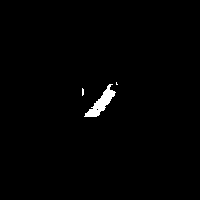

170295_4.png


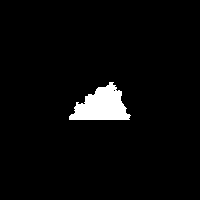

17443_1.png


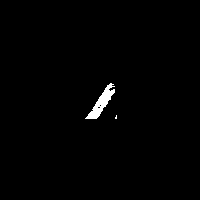

186932_5.png


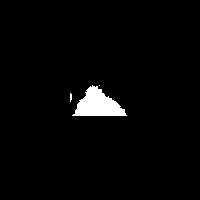

213859_1.png


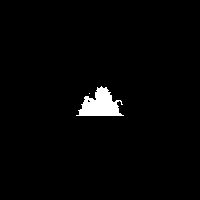

214550_1.png


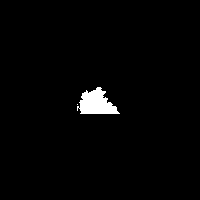

220390_71.png


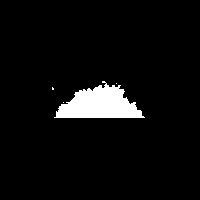

370824_2.png


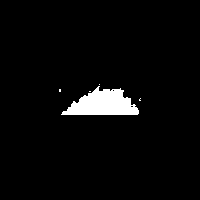

373443_1.png


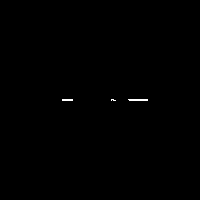

380472_8.png


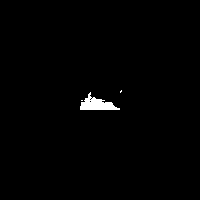

383498_2.png


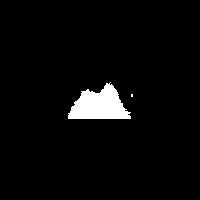

385883_2.png


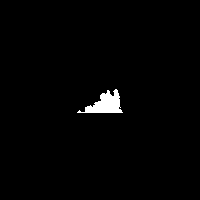

388587_1.png


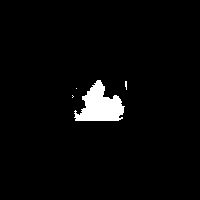

393492_9.png


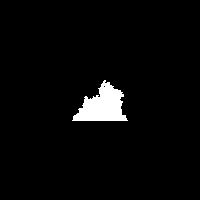

415274_1.png


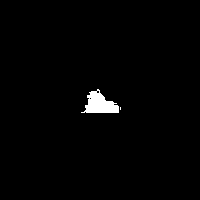

428725_20.png


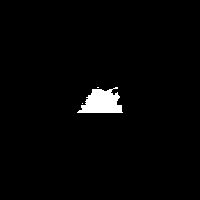

464980_23.png


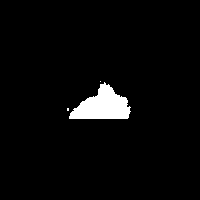

533565_28.png


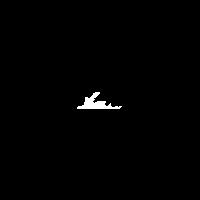

537819_4.png


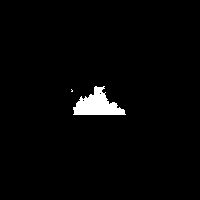

542977_3.png


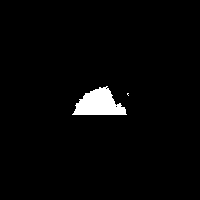

544311_7.png


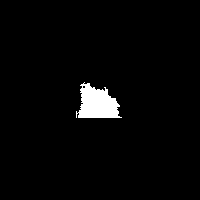

549999_2.png


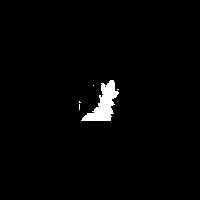

554810_2.png


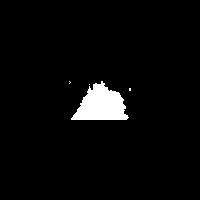

570290_1.png


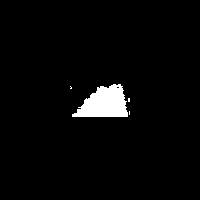

574989_7.png


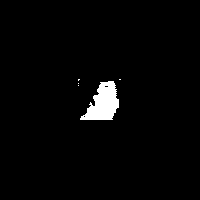

582217_2.png


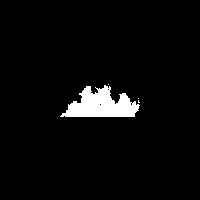

598022_2.png


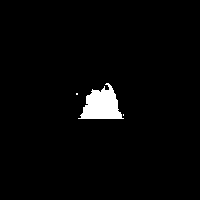

598185_5.png


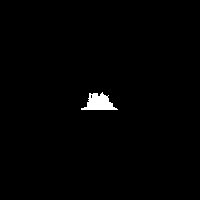

600916_1.png


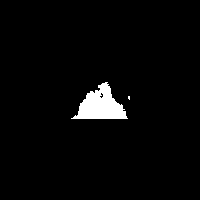

603842_2.png


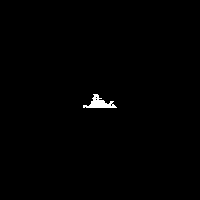

604437_6.png


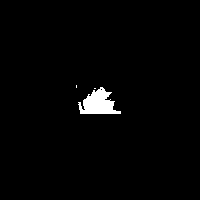

605387_1.png


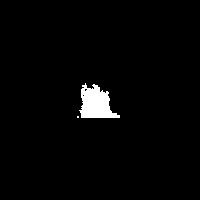

609958_2.png


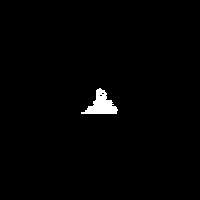

623784_1.png


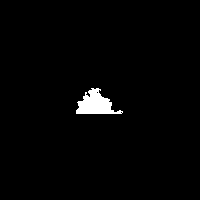

625102_1.png


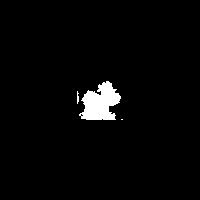

626949_1.png


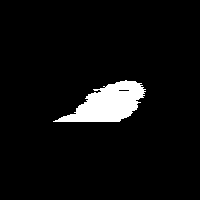

627920_1.png


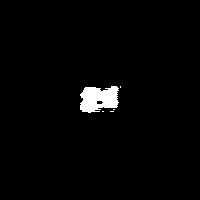

630981_2.png


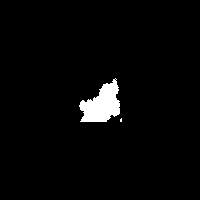

631666_1.png


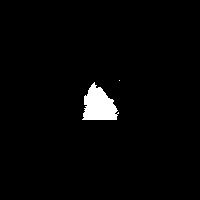

634011_1.png


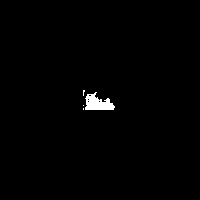

635814_1.png


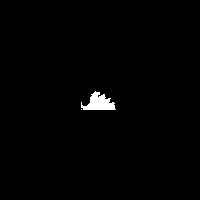

636608_2.png


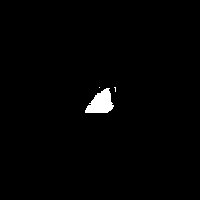

642890_1.png


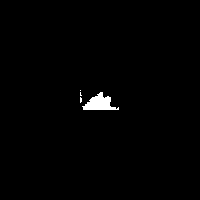

642925_2.png


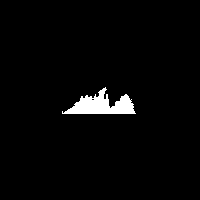

649804_1.png


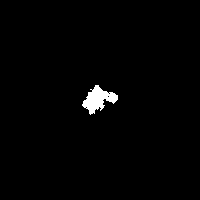

650006_1.png


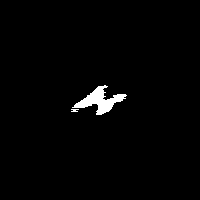

659783_1.png


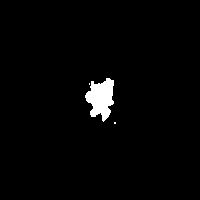

672661_1.png


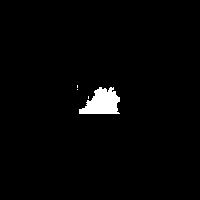

675566_3.png


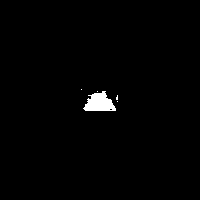

679719_2.png


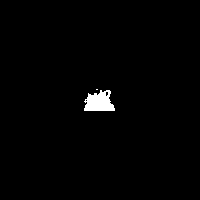

688183_1.png


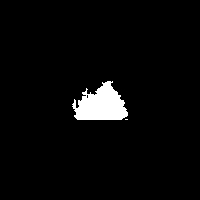

690150_1.png


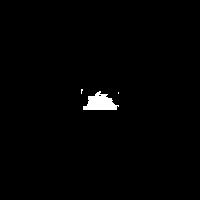

694769_2.png


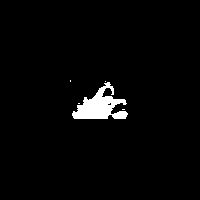

694961_1.png


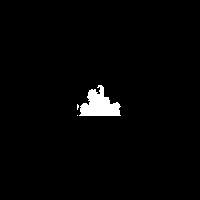

703498_1.png


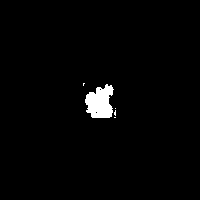

704630_1.png


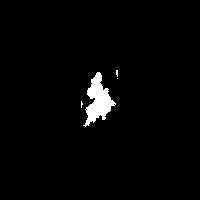

707516_1.png


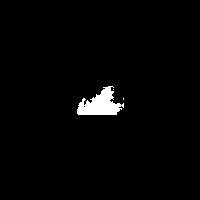

719356_1.png


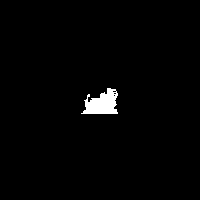

722548_1.png


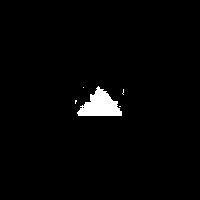

723162_1.png


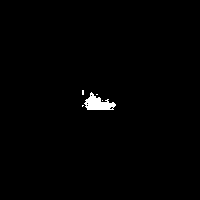

723283_1.png


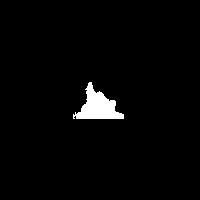

727031_1.png


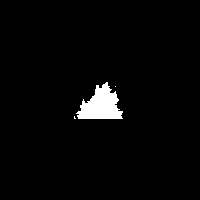

728303_2.png


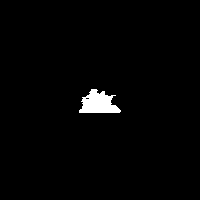

728348_1.png


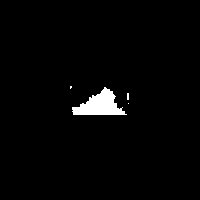

729361_1.png


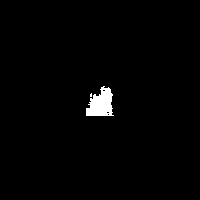

730271_1.png


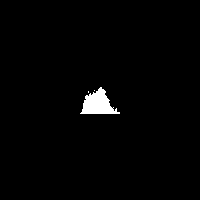

738992_1.png


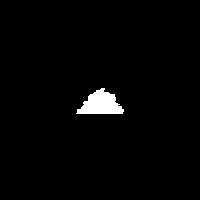

745437_1.png


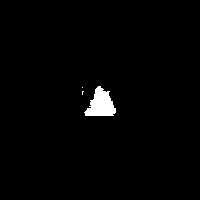

746660_2.png


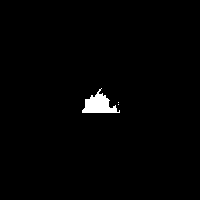

748580_1.png


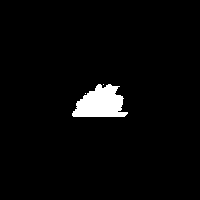

750225_1.png


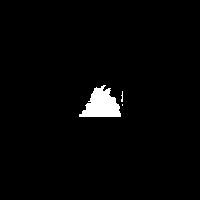

751488_3.png


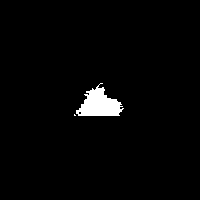

751678_1.png


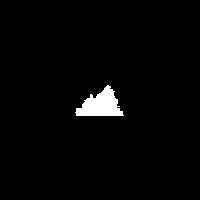

769735_2.png


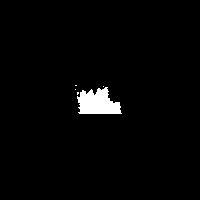

770197_1.png


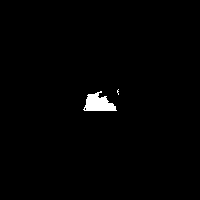

771787_1.png


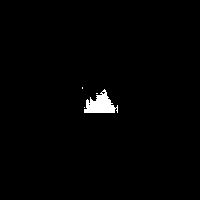

773171_1.png


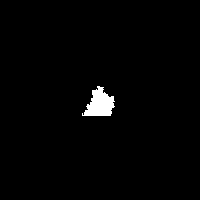

777689_1.png


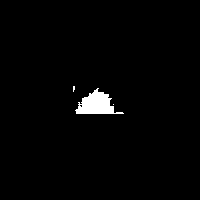

784010_1.png


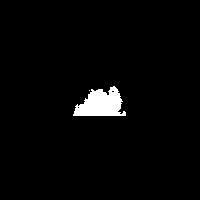

790230_1.png


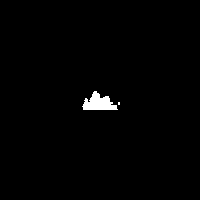

790266_2.png


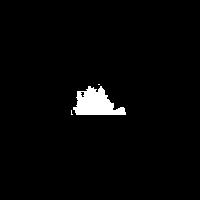

825080_1.png


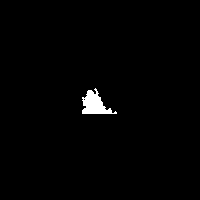

826777_1.png


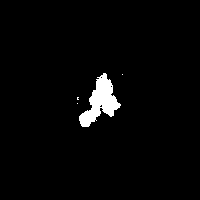

828377_1.png


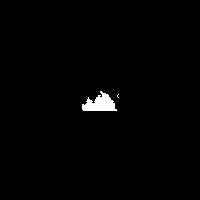

832797_1.png


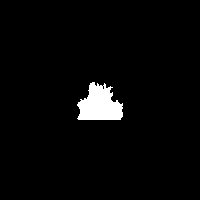

832868_1.png


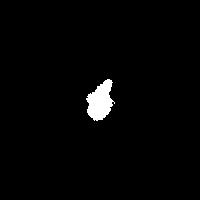

834150_1.png


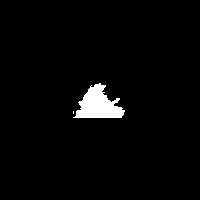

973309_102.png


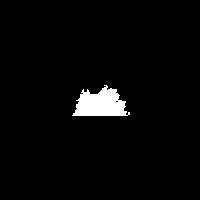

'i then manually looked at image to only have truncated ones in this directory'

In [6]:
# open all the images 
for i in range(len(file_list)):
    print(file_names[i])
    image = f'{file_list[i]}'
    img = Image.open(image)
    display(img)

'''i then manually looked at image to only have truncated ones in this directory'''

In [7]:
# get the particle name, then extract the rows
image_name = [particle[:-4] for particle in file_names]

## filter df according to the list of names
trunacted_img_df = df[df['name'].isin(image_name)]

In [8]:
n = 30
start = trunacted_img_df.iloc[30]['start_index']
end = trunacted_img_df.iloc[30]['end_index']


now open h5 file to mess around with it

In [9]:
h5_path = '/home/users/esree/data/Export_base220730153000.h5'
f2ds = h5py.File(h5_path,'r')

ds_image = f2ds['ImageData'] # shape (128, 200000) --> 128 pixels width, 200000 length
ds_time = f2ds['ImageTimes'] # shape (100000, 3) --> (rows, columns) related to time

# make time variable -> 3 seperate columns
og_t_xr = xr.Dataset({'ImageTimes': (('data', 'time_vars'),ds_time)})
sec_since = og_t_xr['ImageTimes'][:,0] # seconds since midnight UTC
pixel_slice = og_t_xr['ImageTimes'][:,1] # number of slices of pixel per image (contain -1, to fill)
# we can use pixel slice to correcly divide up data ^ the index to call f2ds['ImageData']
# these slices have been pre-determined by Jonny + algorithm he has written 

bit_time = og_t_xr['ImageTimes'][:,2] # 32 bit (instrument things) - not useful
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# do cumulative sum of pixel slices -> can use this as index to slice + extract single crystals
pix_sum = pixel_slice.cumsum(dim='data', dtype ='int')

# shove together into a useful xarray 
time_xr = xr.Dataset({
    'sec_since': sec_since,
    'pixel_slice': pixel_slice,
    'bit_time': bit_time,
    'pix_sum': pix_sum})

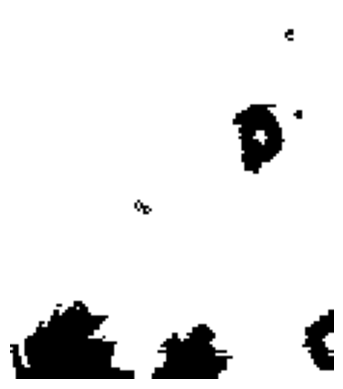

In [11]:
one_crystal = f2ds['ImageData'][:,start:end+70] # extract 1 crystal

plt.imshow(one_crystal, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()